### Adapting Q parameter

This code adaps a previous implementation of the $Q$ and $M$ parameters for light curve asymmetry and periodicity from Cody et al. (2014) to XMM-Newton light curves

In [1]:
import os
import glob
import shutil
from pathlib import Path
from warnings import warn

import numpy as np
#from pysas.wrapper import Wrapper as w

from astropy.table import Table
from astropy.io import fits
import astropy.units as u
from astropy import visualization as avis
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
#from astroquery.simbad import Simbad

import time

import matplotlib.pyplot as plt

from astropy.timeseries import LombScargle, LombScargleMultiband

%matplotlib inline

In [2]:
def get_rms(vec,errvec,med_unc):
    '''Calculate the root mean square of a given light curve, and the error on that rms, given a vector of light curve data,
    a vector of uncertainties, and a median uncertainty.'''
    rms = np.sqrt(np.sum((vec-np.median(vec))**2)/vec.size)
    errors2_vec = ((errvec-med_unc)**2)*2.*((errvec**2)+((np.ones(vec.size))*(med_unc**2)))
    errors2 = np.sqrt(np.sum(errors2_vec))/vec.size
    error = np.sqrt((1./(4.*rms*rms))*errors2*errors2)
    return rms, error

def get_Q(gridflux,smoothCurveOnGrid,fluxerr,medUnc):
    '''Get the Q parameter for a light curve, given the grid flux, the smoothed curve on the grid, the flux error, and the median
    uncertainty.'''
    lightcurveTrendSubtracted = gridflux - smoothCurveOnGrid
    rmsRaw, rmsRawErr = get_rms(gridflux,fluxerr,medUnc) # Get the RMS of the raw light curve
    
    rmsResidual, rmsResidualErr = get_rms(lightcurveTrendSubtracted,fluxerr,medUnc)
    fluxerrQuad = np.sqrt(np.sum(fluxerr**2)/fluxerr.size)
    
    print(rmsRaw, rmsResidual, fluxerrQuad)

    top = (rmsResidual**2 - fluxerrQuad**2)
    bot = (rmsRaw**2 - fluxerrQuad**2)

    Q = top/bot

    dQ = Q * np.sqrt(((2. * (rmsRawErr**2))/(top**2)) + ((2.*(rmsResidualErr**2))/(bot**2)))
    
    return Q, dQ

Read in lightcurve info

In [3]:
lcPNhardFull = Table.read("hltau_tables/lcPNhardFull.ecsv")

In [4]:
testLombScarglePN   = LombScargle(lcPNhardFull['TIMEMJD'],  lcPNhardFull['RATE'],  lcPNhardFull['ERROR'],fit_mean=True)

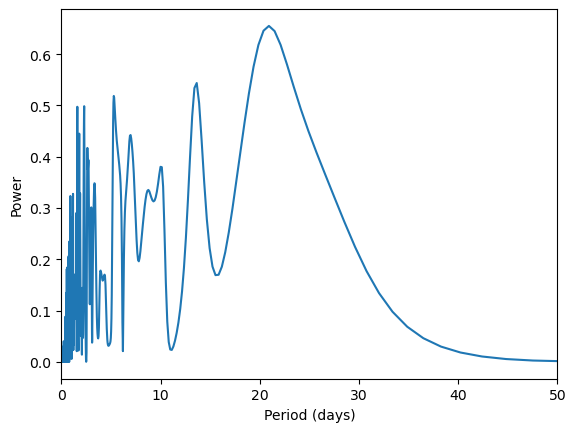

In [5]:
testFreqPN,   testPowerPN   = testLombScarglePN.autopower(samples_per_peak=25)

plt.figure()
plt.plot((1./testFreqPN),  testPowerPN)
plt.xlim([0.,50.])
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.show()

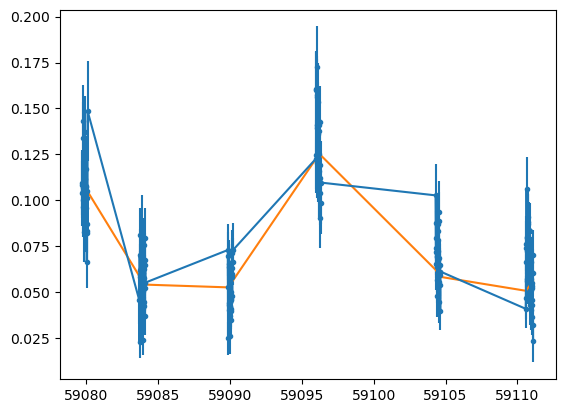

In [6]:
testBestFreqPN = testFreqPN[np.argmax(testPowerPN)]

testCountsPN = testLombScarglePN.model(lcPNhardFull['TIMEMJD'],testBestFreqPN)

plt.figure()
plt.errorbar(lcPNhardFull['TIMEMJD'], lcPNhardFull['RATE'], yerr=lcPNhardFull['ERROR'],marker='.')
plt.plot(lcPNhardFull['TIMEMJD'],testCountsPN)

#plt.xlim([59079.,59082.])

plt.show()

0 0.0008208751678466797 0.0008220672607421875
111 0.012100934982299805 0.00010805896350315638
222 0.01798844337463379 8.066994192354347e-05
333 0.021074295043945312 6.30974055764204e-05
444 0.023941755294799805 5.380169729168495e-05
555 0.03146004676818848 5.658496198036688e-05
666 0.037867069244384766 5.677257520684238e-05
777 0.04032540321350098 5.183244425717234e-05
888 0.04351949691772461 4.895385124283781e-05
999 0.04648113250732422 4.648160934448242e-05


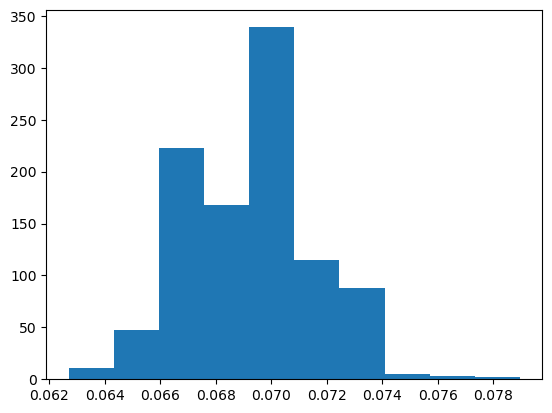

0.06925927
0.06924379616975784 0.0025821998715400696 0.0021924450993537903 0.00238732248544693
0.0022057984


In [7]:
medians = [np.median(lcPNhardFull['RATE'])]

#Generate bootstrapped light curves for estimation of the uncertainty on the median of the light curve
start = time.time()
for i in range(1000):
    testvec = np.random.choice(lcPNhardFull['RATE'],lcPNhardFull['RATE'].size)
    medians.append(np.median(testvec))
    if i%111 < 1:
        print(i, time.time() - start, (time.time()-start)/(i+1))
    
plt.figure()
plt.hist(medians)
plt.show()

dist_perc = np.percentile(medians, [16,50,84])

print(np.median(lcPNhardFull['RATE']))
print(dist_perc[1],dist_perc[1]-dist_perc[0],dist_perc[2]-dist_perc[1],(dist_perc[2]-dist_perc[0])/2.)
print(np.std(medians))

In [8]:
Qtest, Qunctest = get_Q(lcPNhardFull['RATE'], testCountsPN, lcPNhardFull['ERROR'], np.std(medians))

0.03333390045995255 0.017078890515546605 0.014957159841327334


In [9]:
print(Qtest,Qunctest)

0.076593866978195 0.5110802083002299
